In [1]:
%env OMP_NUM_THREADS=2
%env MKL_NUM_THREADS=2
import warnings

env: OMP_NUM_THREADS=2
env: MKL_NUM_THREADS=2


In [2]:
import joblib

In [3]:
%pylab inline
import numpy as np
import pandas as pd
import os
import random
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 3} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
df_sales_train = pd.read_csv('../data/sales_train_evaluation.csv', dtype={f'd_{i}': np.int32 for i in range(0, 1948)})
# df_sell_prices = pd.read_csv('../data/sell_prices.csv')
df_calendar = pd.read_pickle('../data/processed/calendar_OHE.pkl')

In [6]:
tmp = df_sales_train.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'group'], axis=1, errors='ignore').T
tmp = tmp.rename(columns=tmp.iloc[0]).drop(tmp.index[0])
tmp = tmp.astype(float)

In [7]:
df_sales_train['group'] = (df_sales_train['store_id'] + '_' + df_sales_train['cat_id'] + '_' + df_sales_train['dept_id'])

df_sales_train: Generate cyclical encoding of time variables

In [8]:
d_mapper = {i: j for (i, j) in df_calendar[['d', 'date']].values}
tmp.index = [d_mapper[x] for x in tmp.index]

In [9]:
train_date = tmp.index[:-28]
train = tmp[:-28].copy()

test_date = tmp.index[-28:]
test = tmp[-28:].copy()

print(train.shape, test.shape)

(1913, 30490) (28, 30490)


In [10]:
df_diff = tmp.diff(7).dropna()

In [11]:
df_exog = df_calendar.copy()
df_exog = df_exog.iloc[7:].copy().set_index('date')

In [12]:
def sincos_encoding(series):
    """
    Encode a series, like dates and time into sine and cosine forms to preserve cyclical nature.
    """
    sin_enc = np.sin(2 * np.pi * series/series.max())
    cos_enc = np.cos(2 * np.pi * series/series.max())
    
    return sin_enc, cos_enc

In [13]:
for col in ['wday', 'month']:
    sin_enc, cos_enc = sincos_encoding(df_exog[col])
    df_exog[col + '_sin'] = sin_enc
    df_exog[col + '_cos'] = cos_enc
    
df_exog = df_exog.drop(['wday', 'month', 'd'], axis=1, errors='ignore')
df_exog = df_exog.astype(float)

In [272]:
train_diff = df_diff.iloc[:len(train),:].copy()
test_diff = df_diff.loc[test.index].copy()

train_init = tmp.loc[train_diff.index].copy()
test_init = tmp.loc[test_diff.index].copy()

train_ext = df_exog.loc[train_diff.index].copy()
test_ext = df_exog.loc[test_diff.index].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(1913, 30490) (1913, 30490) (1913, 56)
(28, 30490) (28, 30490) (28, 56)


### VAR 

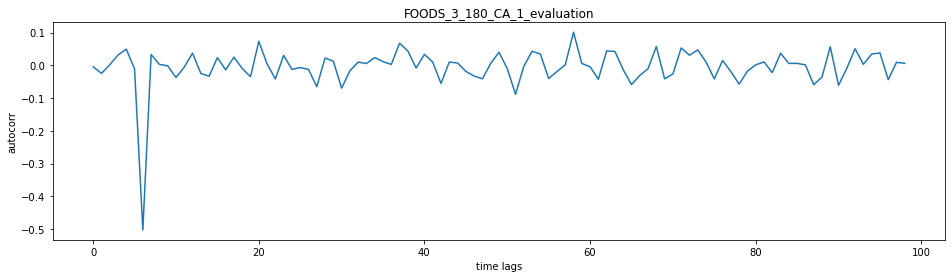

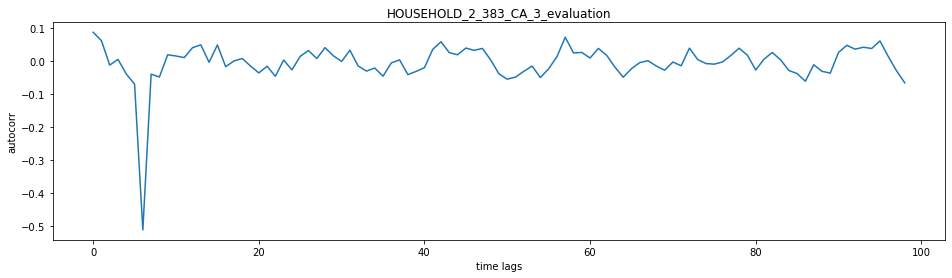

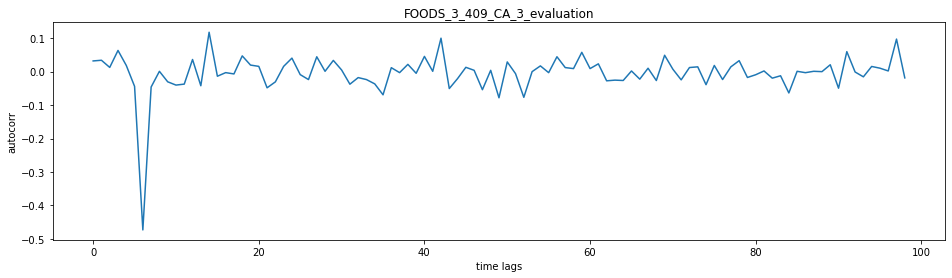

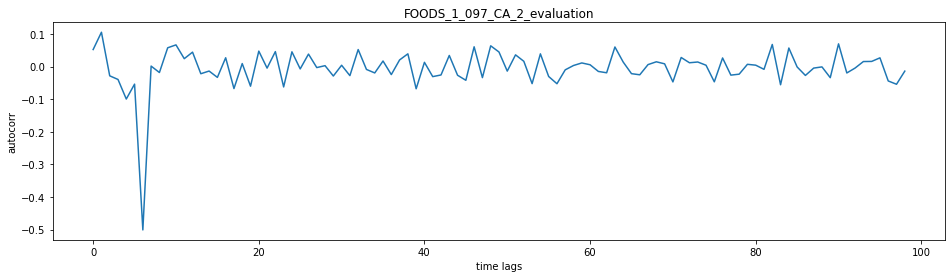

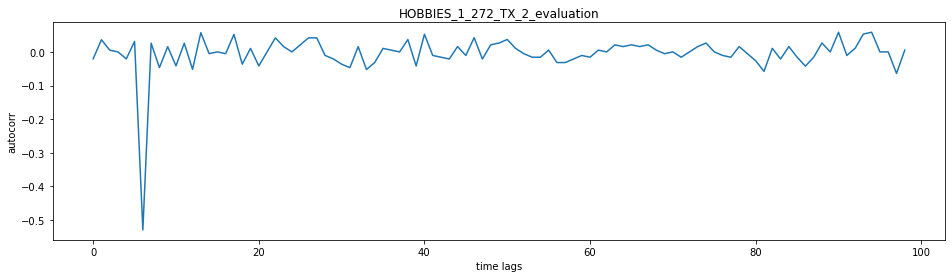

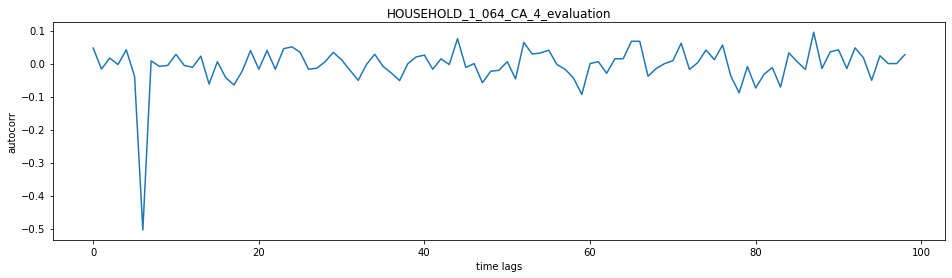

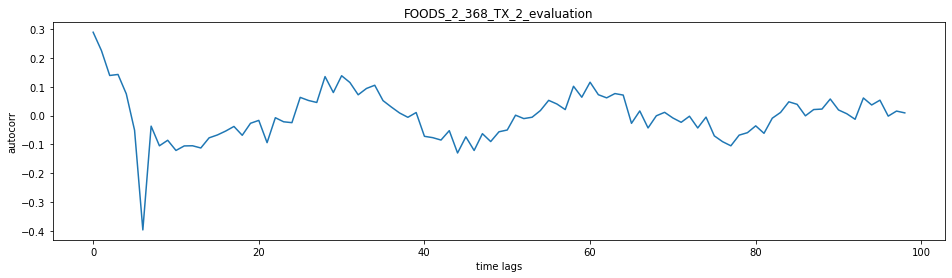

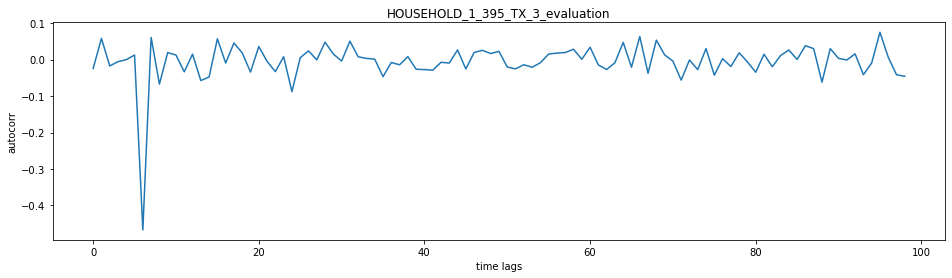

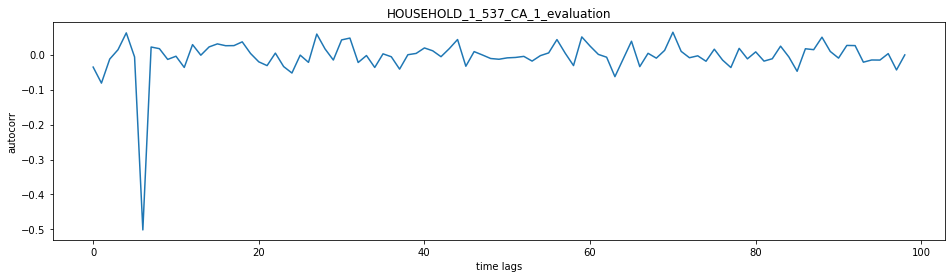

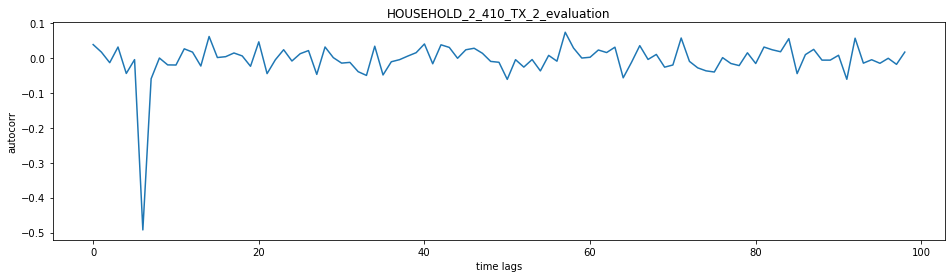

In [15]:
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    time_lags = np.arange(1,100)
    plt.plot([df[name].autocorr(dt) for dt in time_lags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()
    
for col in tmp.sample(10, axis=1, random_state=42).columns:
    plot_autocor(col, train_diff)

In [16]:
# try:
#     best_orders = joblib.load('../data/processed/VAR_group_order')
# except:
best_orders = {}

In [17]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    for group in df_sales_train['group'].drop_duplicates().values:
        if group in best_orders:
            continue
        grouped_items = df_sales_train.groupby(['group']).get_group(group)['id'].values
        AIC = {}
        best_aic, best_order, best_trend = np.inf, 0, None

        for i in tqdm(range(1,32)):
            for trend in ['ctt', 'c', 'ct', 'nc']:
                model = VAR(endog=train_diff[grouped_items])
                model_result = model.fit(maxlags=i, trend=trend)
                try:
                    res_aic = model_result.aic
                except Exception as e:
                    print(i, e)
                    res_aic = np.inf

                AIC[i] = res_aic

                if AIC[i] < best_aic:
                    best_aic = AIC[i]
                    best_order = i
                    best_trend = trend
        print('BEST ORDER', best_order, 'BEST TREND', trend, 'BEST AIC:', best_aic)
        best_orders[group] = (best_order, best_trend)
        joblib.dump(best_orders, '../data/processed/VAR_group_order_trend')


BEST ORDER 6 BEST TREND nc BEST AIC: -49318.35896520573


4 244-th leading minor of the array is not positive definite
4 248-th leading minor of the array is not positive definite
4 245-th leading minor of the array is not positive definite
4 246-th leading minor of the array is not positive definite
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')

BEST ORDER 7 BEST TREND nc BEST AIC: -26177.568320187675


12 111-th leading minor of the array is not positive definite
12 113-th leading minor of the array is not positive definite
12 113-th leading minor of the array is not positive definite
12 115-th leading minor of the array is not positive definite

BEST ORDER 16 BEST TREND nc BEST AIC: -9582.54904013129


3 312-th leading minor of the array is not positive definite
3 316-th leading minor of the array is not positive definite
3 315-th leading minor of the array is not positive definite
3 315-th leading minor of the array is not positive definite
4 (34, 'Result too large')
4 (34, 'Result too large')
4 (34, 'Result too large')
4 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')

BEST ORDER 7 BEST TREND nc BEST AIC: -32896.48575960569


3 364-th leading minor of the array is not positive definite
3 366-th leading minor of the array is not positive definite
3 365-th leading minor of the array is not positive definite
3 367-th leading minor of the array is not positive definite
4 (34, 'Result too large')
4 (34, 'Result too large')
4 (34, 'Result too large')
4 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')

BEST ORDER 7 BEST TREND nc BEST AIC: -32729.454189494234


8 175-th leading minor of the array is not positive definite
8 178-th leading minor of the array is not positive definite
8 178-th leading minor of the array is not positive definite
8 178-th leading minor of the array is not positive definite
9 (34, 'Result too large')
9 (34, 'Result too large')
9 (34, 'Result too large')
9 (34, 'Result too large')

BEST ORDER 11 BEST TREND nc BEST AIC: -13485.934917864248


4 315-th leading minor of the array is not positive definite
4 318-th leading minor of the array is not positive definite
4 318-th leading minor of the array is not positive definite
4 319-th leading minor of the array is not positive definite
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')
6 (34, 'Result too large')

BEST ORDER 7 BEST TREND nc BEST AIC: -24818.56698447005


1 (34, 'Result too large')
1 (34, 'Result too large')
1 (34, 'Result too large')
1 (34, 'Result too large')
2 263-th leading minor of the array is not positive definite
2 265-th leading minor of the array is not positive definite
2 264-th leading minor of the array is not positive definite
2 266-th leading minor of the array is not positive definite
3 (34, 'Result too large')
3 (34, 'Result too large')
3 (34, 'Result too large')
3 (34, 'Result too large')
4 (34, 'Result too large')
4 (34, 'Result too large')
4 (34, 'Result too large')
4 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')
5 (34, 'Result too large')

BEST ORDER 6 BEST TREND nc BEST AIC: -49355.08657559769


In [18]:
class NaiveMeanModel:
    """
    Substitute model for when VAR is unable to generate predictions.
    """
    def __init__(self, endog, window=7):
        self.endog = endog
        self.window = 7
        
    def forecast(self, y, steps):
        return np.repeat(pd.DataFrame(self.endog).rolling(self.window).mean().iloc[-1].values.reshape(-1, 1), steps, axis=1).T
    
    def fittedvalues(self):
        return endog

In [23]:
var_models = {}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    for group in df_sales_train['group'].drop_duplicates().values:
        try:
            grouped_items = df_sales_train.groupby(['group']).get_group(group)['id'].values
            # Train VAR models per group
            var = VAR(endog=train_diff[grouped_items].values)
            var_result = var.fit(maxlags=best_orders[group][0], trend=best_orders[group][1])
            var_models[group] = var_result
            print(f'group: {group}, AIC: {var_result.aic}')
        except Exception as e:
            print(f'group {group} - {e}')
            var_models[group] = NaiveMeanModel(train_diff[grouped_items].values)

group: CA_1_HOBBIES_HOBBIES_1, AIC: -25794.036498743437
group: CA_1_HOBBIES_HOBBIES_2, AIC: -9532.888453491561
group: CA_1_HOUSEHOLD_HOUSEHOLD_1, AIC: -32798.93986351621
group: CA_1_HOUSEHOLD_HOUSEHOLD_2, AIC: -32399.40487094964
group: CA_1_FOODS_FOODS_1, AIC: -13374.360439144522
group: CA_1_FOODS_FOODS_2, AIC: -24793.436385198765
group: CA_1_FOODS_FOODS_3, AIC: -49079.726344085386
group: CA_2_HOBBIES_HOBBIES_1, AIC: -25977.80401384748
group: CA_2_HOBBIES_HOBBIES_2, AIC: -9520.077750350918
group: CA_2_HOUSEHOLD_HOUSEHOLD_1, AIC: -32790.12953036442
group: CA_2_HOUSEHOLD_HOUSEHOLD_2, AIC: -32215.102845913418
group: CA_2_FOODS_FOODS_1, AIC: -13271.491174566276
group: CA_2_FOODS_FOODS_2, AIC: -24395.14100188246
group: CA_2_FOODS_FOODS_3, AIC: -49526.1082166603
group: CA_3_HOBBIES_HOBBIES_1, AIC: -25788.96793474353
group: CA_3_HOBBIES_HOBBIES_2, AIC: -9482.877316924918
group: CA_3_HOUSEHOLD_HOUSEHOLD_1, AIC: -32435.33923359056
group: CA_3_HOUSEHOLD_HOUSEHOLD_2, AIC: -32132.788631749056
grou

In [24]:
def VAR_predict(var_model, prior, prior_init, steps, period=7):
    
    pred = var_model.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

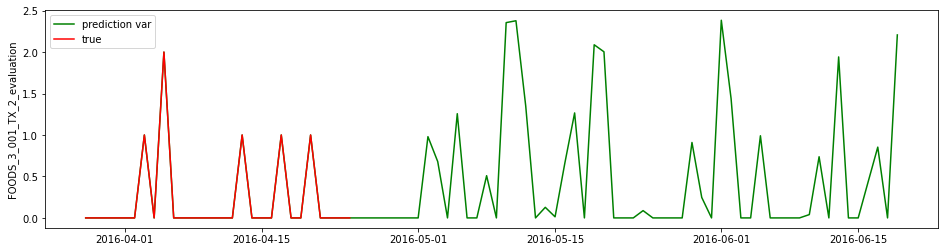

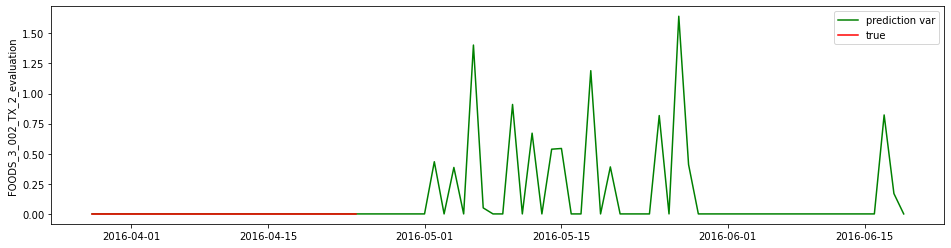

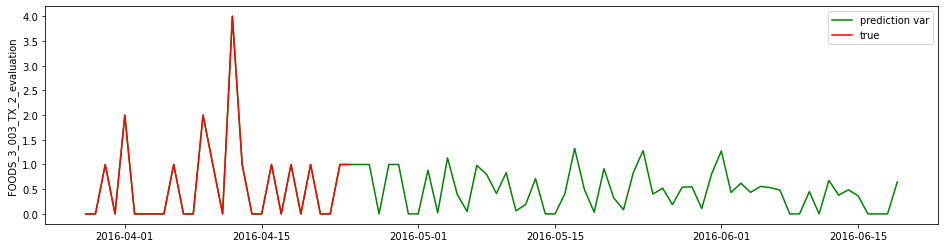

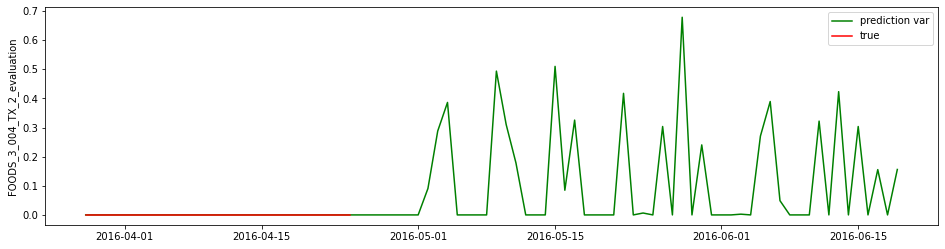

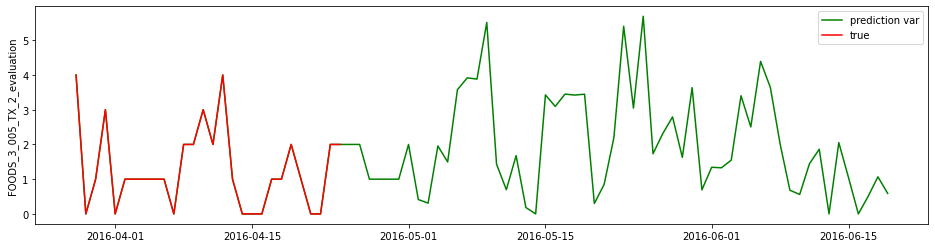

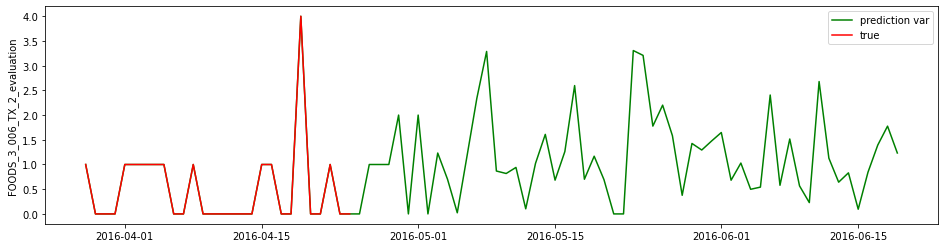

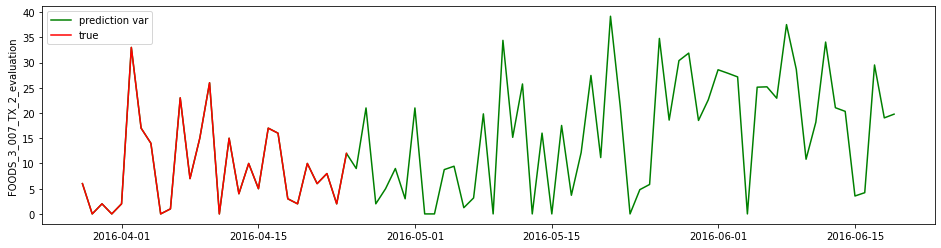

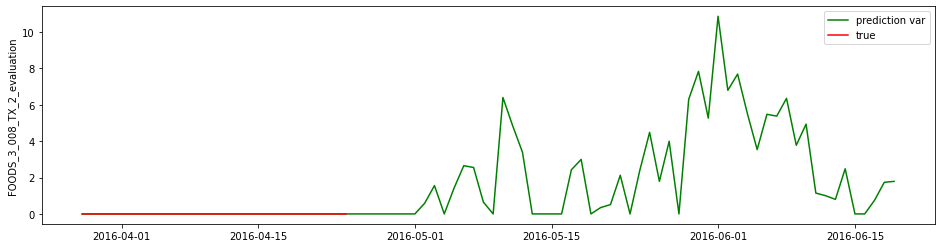

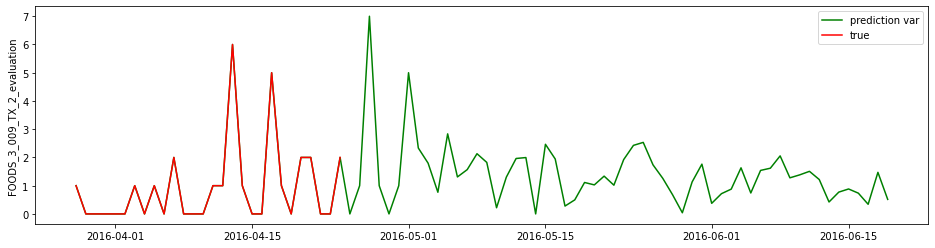

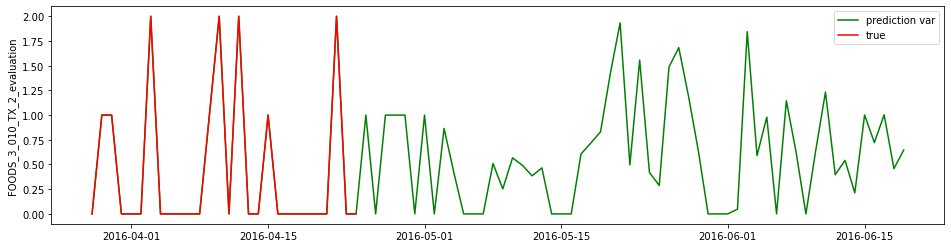

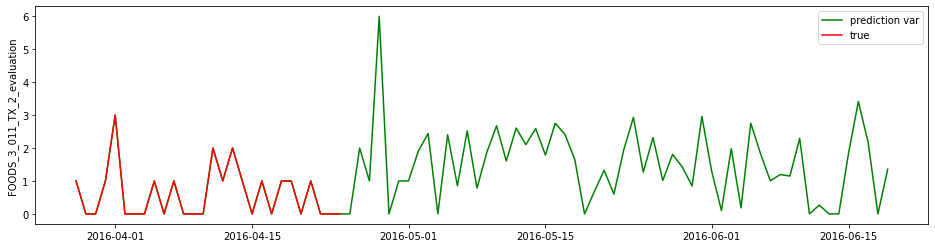

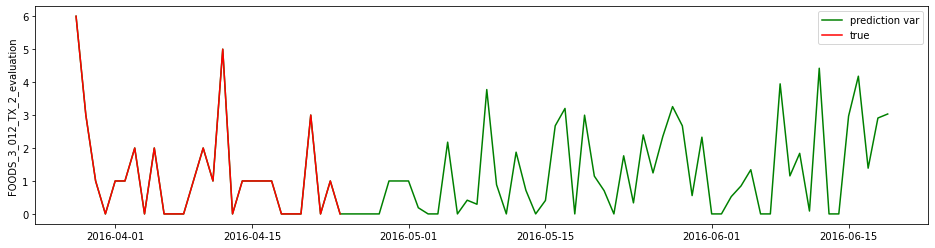

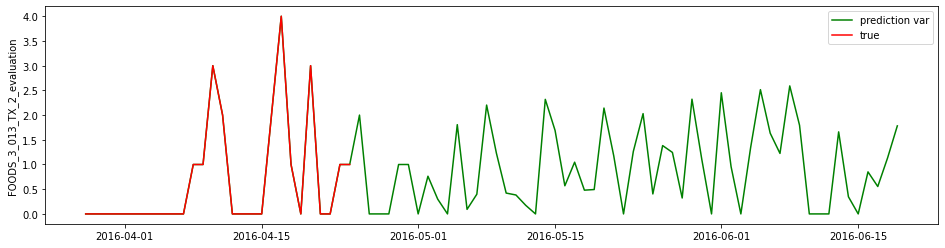

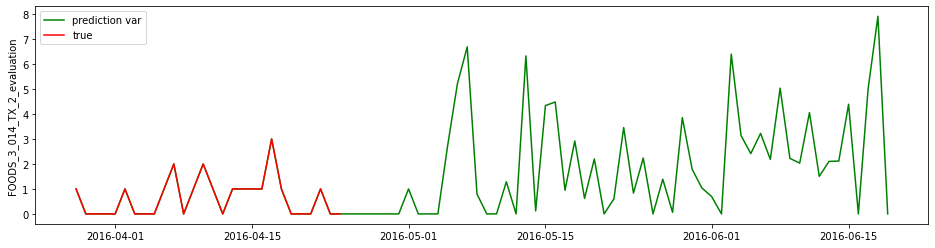

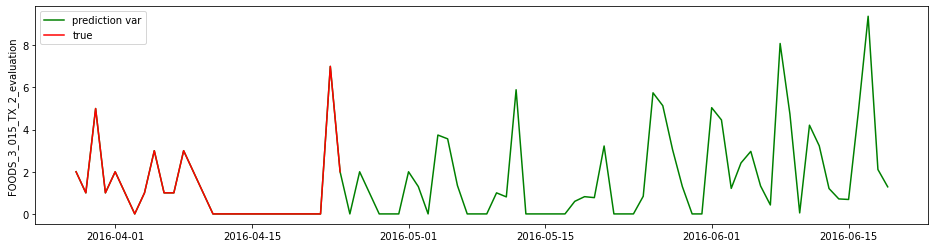

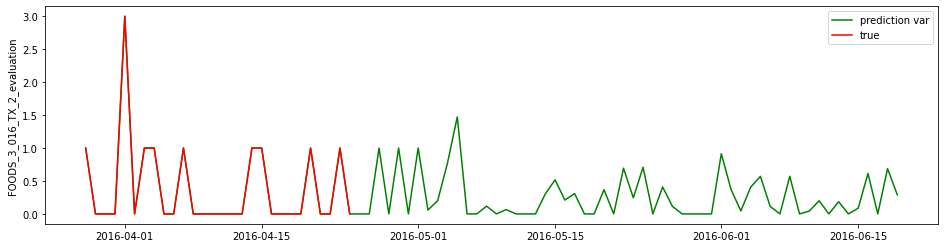

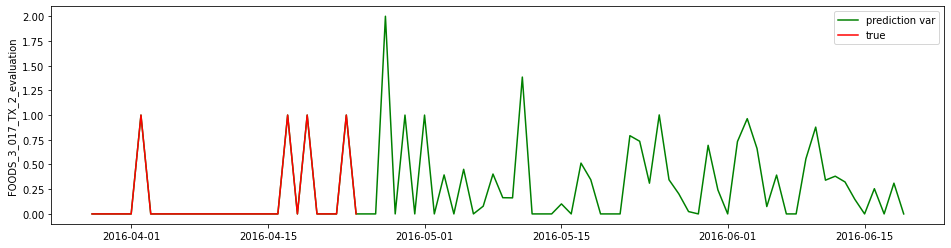

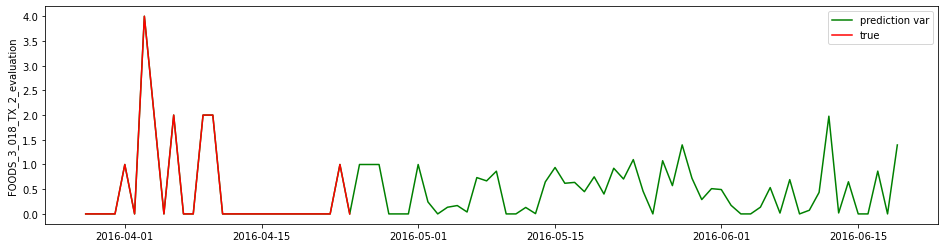

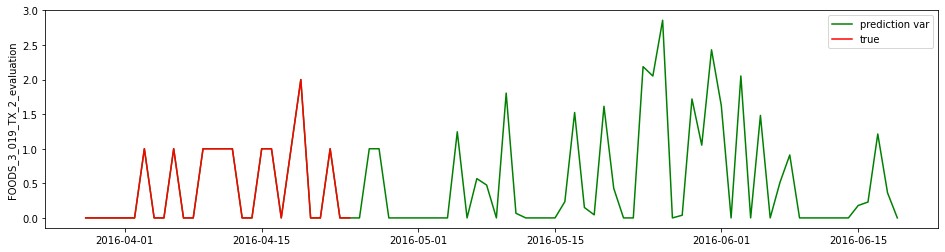

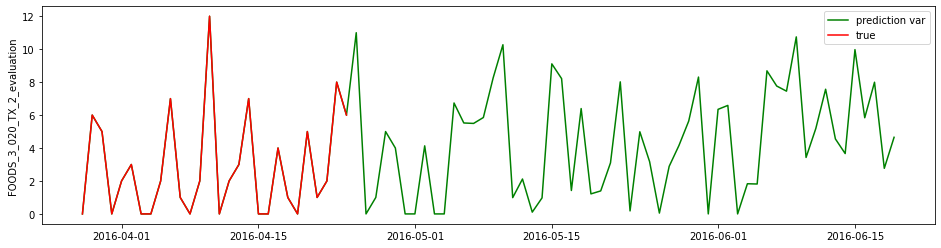

In [142]:
date = train_date[-29]
forward = 28 * 3
date_range = pd.date_range(date, periods=forward+1, freq='D', closed='right')

group = 'TX_2_FOODS_FOODS_3'
grouped_items = df_sales_train.groupby(['group']).get_group(group)['id'].values
final_pred = VAR_predict(var_models[group], train_diff[grouped_items].loc[:date], train[grouped_items].loc[:date], steps = forward).clip(0)
final_true = train[grouped_items].loc[date_range[:-28*2]]

for i,col in enumerate(grouped_items[:20]):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range[:-28*2], final_true[col].values, c='red', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

In [405]:
df_res = pd.DataFrame()
for group in df_sales_train['group'].drop_duplicates().values:
    grouped_items = df_sales_train.groupby(['group']).get_group(group)['id'].values
    final_pred = VAR_predict(var_models[group], train_diff[grouped_items].loc[:date], train[grouped_items].loc[:date], steps = forward).clip(0)
    df_res = df_res.append(pd.DataFrame(final_pred[28:56].T, index=grouped_items))

In [406]:
df_res.columns = [f'd_{i}' for i in (df_res.columns + 1914)]

In [407]:
df_res.to_csv('../data/results/VAR.csv')

In [141]:
del df_res

## LSTM

In [390]:
group = 'TX_2_FOODS_FOODS_3'
grouped_items = df_sales_train.groupby(['group']).get_group(group)['id'].values
best_order, best_trend = best_orders[group]
X = var_models[group].fittedvalues

In [391]:
y_train = train_init[grouped_items].iloc[1500:]

In [392]:
y_train_var = X[1500:] + train_init[grouped_items].iloc[1500+best_order:]

In [393]:
X_train = np.concatenate([train_diff[grouped_items].iloc[1500+best_order:], train_ext.iloc[1500+best_order:]], axis=1)

In [394]:
X_train_var = np.concatenate([X[1500:], train_ext.iloc[1500+best_order:].values], axis=1)

In [395]:
y_val = y_train[int(len(y_train)*0.8):]
y_val_var = y_train_var[int(len(y_train)*0.8):]
X_val = X_train[int(len(y_train)*0.8):]
X_val_var = X_train_var[int(len(y_train)*0.8):]

y_train = y_train[:int(len(y_train)*0.8)]
y_train_var = y_train_var[:int(len(y_train)*0.8)]
X_train = X_train[:int(len(y_train)*0.8)]
X_train_var = X_train_var[:int(len(y_train)*0.8)]

y_test = test[grouped_items].values
X_test = np.concatenate([test_diff[grouped_items].values, test_ext.values], axis=1)

In [397]:
scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [398]:
seq_length = 7

In [408]:
generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=32)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=32)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)

ValueError: Data and targets have to be of same length. Data length is 264 while target length is 330

In [314]:
generator_val_var[0][1].shape

(32, 823)

In [341]:
def create_LSTM_model(num_features, seq_length, pred_length, output_shape):

    opt = RMSprop(lr=0.002)

    inp = Input(shape=(seq_length, num_features))

    x = LSTM(256)(inp)
    x = Dropout(0.5)(x)
    x = Dense(int(output_shape ** 0.5), activation='relu')(x)
    x = Dropout(0.5)(x)

    out = Dense(output_shape)(x)

    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    return model

In [342]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.0001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')
model_var = create_LSTM_model(num_features=879, seq_length=seq_length, pred_length=seq_length, output_shape=generator_val_var[0][1].shape[1])
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=100, validation_data=generator_val_var, validation_steps = len(generator_val_var), 
                        callbacks=[es], verbose = 1)


print('--------', 'train model with raw data', '--------')
model_var.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                        epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
Epoch 1/100
48/48 [==============================] - 2s 37ms/step - loss: 3.9228 - val_loss: 12.1269
Epoch 2/100
48/48 [==============================] - 2s 36ms/step - loss: 3.9096 - val_loss: 12.1191
Epoch 3/100
48/48 [==============================] - 2s 36ms/step - loss: 3.8958 - val_loss: 12.0761
Epoch 4/100
48/48 [==============================] - 2s 36ms/step - loss: 3.8715 - val_loss: 12.0482
Epoch 5/100
48/48 [==============================] - 2s 37ms/step - loss: 3.8552 - val_loss: 12.0438
Epoch 6/100
48/48 [==============================] - 2s 36ms/step - loss: 3.8398 - val_loss: 12.0257
Epoch 7/100
48/48 [==============================] - 2s 36ms/step - loss: 3.8246 - val_loss: 12.0207
Epoch 8/100
48/48 [==============================] - 2s 35ms/step - loss: 3.8152 - val_loss: 12.0221
Epoch 9/100
48/48 [==============================] - 2s 37ms/step - loss: 3.8058 - val_loss: 12.0144
Epoch 10/100
48/48 [==================

In [343]:
true = scaler_y.inverse_transform(y_test[seq_length:])

pred = model_var.predict_generator(generator_test)
pred = scaler_y.inverse_transform(pred)

In [344]:
mean_absolute_error(true, pred)

1.7000880256670632

In [346]:
simple_model = create_LSTM_model(num_features=879, seq_length=seq_length, pred_length=seq_length, output_shape=generator_val_var[0][1].shape[1])
simple_model.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                            epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                            callbacks=[es], verbose = 1)

Epoch 1/100
48/48 [==============================] - 2s 37ms/step - loss: 1.0334 - val_loss: 3.3526
Epoch 2/100
48/48 [==============================] - 2s 36ms/step - loss: 1.0133 - val_loss: 3.3165
Epoch 3/100
48/48 [==============================] - 2s 37ms/step - loss: 0.9848 - val_loss: 3.2819
Epoch 4/100
48/48 [==============================] - 2s 37ms/step - loss: 0.9674 - val_loss: 3.2579
Epoch 5/100
48/48 [==============================] - 2s 36ms/step - loss: 0.9520 - val_loss: 3.2175
Epoch 6/100
48/48 [==============================] - 2s 37ms/step - loss: 0.9367 - val_loss: 3.2419
Epoch 7/100
48/48 [==============================] - 2s 35ms/step - loss: 0.9267 - val_loss: 3.2286
Epoch 8/100
48/48 [==============================] - 2s 36ms/step - loss: 0.9181 - val_loss: 3.2112
Epoch 9/100
48/48 [==============================] - 2s 36ms/step - loss: 0.9114 - val_loss: 3.1936
Epoch 10/100
48/48 [==============================] - 2s 36ms/step - loss: 0.9047 - val_loss: 3.2091

In [347]:
pred_simple = simple_model.predict_generator(generator_test)
pred_simple = scaler_y.inverse_transform(pred_simple)
mean_absolute_error(true, pred_simple)

1.7009977536925893

In [353]:
from scipy.stats import pearsonr
def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]

In [358]:
diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}


for i,col in enumerate(grouped_items):
    
    error = mean_absolute_error(true[:,i], pred_simple[:,i])
    diz_error_lstm[col] = error
    
    error = mean_absolute_error(true[:,i], pred[:,i])
    diz_error_var_lstm[col] = error
    
    ac = autocor_pred(true[:,i], pred_simple[:,i])
    diz_ac_lstm[col] = ac
    
    ac = autocor_pred(true[:,i], pred[:,i])
    diz_ac_var_lstm[col] = ac

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is consta

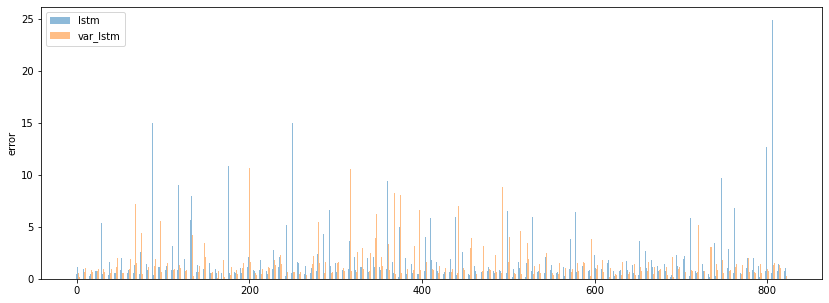

In [359]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
# plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)